In [1]:
import pandas as pd

df = pd.read_csv("car_fuel_efficiency.csv")

# Keeping only the required columns
cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df = df[cols]

count    9704.000000
mean       14.985243
std         2.556468
min         6.200971
25%        13.267459
50%        15.006037
75%        16.707965
max        25.967222
Name: fuel_efficiency_mpg, dtype: float64


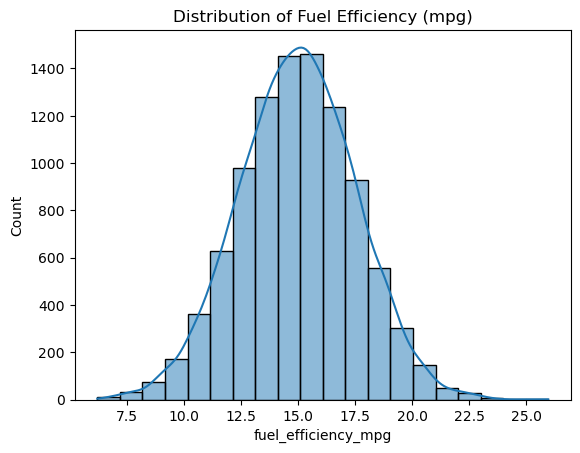

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic stats
print(df['fuel_efficiency_mpg'].describe())

# Plot histogram
sns.histplot(df['fuel_efficiency_mpg'], kde=True, bins=20)
plt.title("Distribution of Fuel Efficiency (mpg)")
plt.xlabel("fuel_efficiency_mpg")
plt.show()

In [3]:
df['fuel_efficiency_mpg'].skew()

-0.012062219273507929

In [4]:
df.isnull().sum()

engine_displacement      0
horsepower             708
vehicle_weight           0
model_year               0
fuel_efficiency_mpg      0
dtype: int64

In [5]:
df['horsepower'].median()

149.0

In [6]:
from sklearn.model_selection import train_test_split

# Drop missing values
df = df.dropna(subset=['horsepower']).copy()

# Shuffle the dataset with random_state=42
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split into train (60%) and temp (40%)
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)

# Split temp into validation (20%) and test (20%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Print shapes to confirm
print(f"Train set: {len(train_df)} rows")
print(f"Validation set: {len(val_df)} rows")
print(f"Test set: {len(test_df)} rows")

Train set: 5397 rows
Validation set: 1799 rows
Test set: 1800 rows


In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

# Features and target
features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
target = 'fuel_efficiency_mpg'

X_train = train_df[features].copy()
y_train = train_df[target].copy()

X_val = val_df[features].copy()
y_val = val_df[target].copy()

In [8]:
# Fill missing values with 0
X_train_0 = X_train.fillna(0)
X_val_0 = X_val.fillna(0)

# Train linear regression
model_0 = LinearRegression()
model_0.fit(X_train_0, y_train)

# Predict and evaluate RMSE
y_pred_0 = model_0.predict(X_val_0)
rmse_0 = np.sqrt(mean_squared_error(y_val, y_pred_0))
print("RMSE (fill with 0):", round(rmse_0, 2))


RMSE (fill with 0): 0.45


In [9]:
# Compute mean from training set only
mean_hp = X_train['horsepower'].mean()

# Fill missing with training mean
X_train_mean = X_train.fillna(mean_hp)
X_val_mean = X_val.fillna(mean_hp)

# Train linear regression
model_mean = LinearRegression()
model_mean.fit(X_train_mean, y_train)

# Predict and evaluate RMSE
y_pred_mean = model_mean.predict(X_val_mean)
rmse_mean = np.sqrt(mean_squared_error(y_val, y_pred_mean))
print("RMSE (fill with mean):", round(rmse_mean, 2))


RMSE (fill with mean): 0.45


In [10]:
if rmse_0 < rmse_mean:
    print("Better option: Fill with 0")
elif rmse_mean < rmse_0:
    print("Better option: Fill with mean")
else:
    print("Both are equally good")

Both are equally good


In [11]:
# List of r (regularization strengths) to try
r_list = [0, 0.01, 0.1, 1, 5, 10, 100]

In [12]:
from sklearn.linear_model import Ridge

rmse_scores = {}

for r in r_list:
    model = Ridge(alpha=r)
    model.fit(X_train_0, y_train)
    y_pred = model.predict(X_val_0)
    rmse_scores[r] = round(np.sqrt(mean_squared_error(y_val, y_pred)), 2)

In [13]:
for r, score in rmse_scores.items():
    print(f"r={r}, RMSE={score}")

r=0, RMSE=0.45
r=0.01, RMSE=0.45
r=0.1, RMSE=0.45
r=1, RMSE=0.45
r=5, RMSE=0.45
r=10, RMSE=0.45
r=100, RMSE=0.45


In [14]:
min_rmse = min(rmse_scores.values())
best_r = min(r for r, score in rmse_scores.items() if score == min_rmse)

print(f"Best r: {best_r} with RMSE={min_rmse}")

Best r: 0 with RMSE=0.45


In [15]:
cols = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df_filtered = df[cols].dropna(subset=['horsepower']).copy()

In [16]:
seeds = list(range(10))  # 0 to 9
rmse_list = []

for seed in seeds:
    # Shuffle and split (60/20/20)
    df_shuffled = df_filtered.sample(frac=1, random_state=seed).reset_index(drop=True)
    train_df, temp_df = train_test_split(df_shuffled, test_size=0.4, random_state=seed)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=seed)
    
    # Features and target
    features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
    target = 'fuel_efficiency_mpg'
    
    X_train = train_df[features].fillna(0)
    y_train = train_df[target]
    
    X_val = val_df[features].fillna(0)
    y_val = val_df[target]
    
    # Train linear regression
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Predict and compute RMSE
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_list.append(rmse)


In [17]:
std_rmse = np.std(rmse_list)
print("Standard deviation of RMSEs:", round(std_rmse, 3))

Standard deviation of RMSEs: 0.008


In [18]:
train_val_df = pd.concat([train_df, val_df], ignore_index=True)

features = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year']
target = 'fuel_efficiency_mpg'

X_train_val = train_val_df[features].fillna(0)
y_train_val = train_val_df[target]

X_test = test_df[features].fillna(0)
y_test = test_df[target]

In [19]:
model = Ridge(alpha=0.001)
model.fit(X_train_val, y_train_val)

Ridge(alpha=0.001)

In [20]:
y_pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print("Test RMSE:", round(rmse_test, 3))

Test RMSE: 0.468
